# Setup

In [ ]:
#@title ## Base imports
import os
import cmd
import sys
import json
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import sklearn.calibration
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn.metrics
import textwrap

import skimage
import skimage.io
import PIL
import PIL.Image
import requests

import IPython.display
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots

# Display versions of python packages
pip_versions = %system pip freeze  # uses colab magic to get list from shell
pip_versions_organized = {
    "standard": [pip_version for pip_version in pip_versions if "==" in pip_version],
    "other": [pip_version for pip_version in pip_versions if "==" not in pip_version]
    }
print(f"Python version: {sys.version} \n")  # display version of python itself (i.e. 3.8.10)
cli = cmd.Cmd()
cli.columnize(pip_versions_organized["standard"], displaywidth=800)
cli.columnize(pip_versions_organized["other"], displaywidth=160)

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] 

absl-py==1.4.0                autograd==1.6.2         cffi==1.16.0               contourpy==1.2.1       distro==1.7.0             fastcore==1.5.46        gcsfs==2023.6.0                      google-cloud-aiplatform==1.56.0           googledrivedownloader==0.4  humanize==4.7.0             ipykernel==5.5.6                      jupyter-console==6.1.0      lightgbm==4.1.0             mistune==0.8.4           nbformat==5.10.4                   optax==0.2.2                pickleshare==0.7.5         prophet==1.1.5             pydot-ng==2.0.0          pyshp==2.3.1            regex==2024.5.15            sentencepiece==0.1.99           sphinxcontrib-devhelp==1.0.6           tensorboard==2.15.2                   tifffile==2024.5.22                typing_extensions==4.12.2  xarray==2023.7.0      
aiohttp==3.9.5                Babel==2.15.0           chardet==5.2.0             cryptography==42.0.8   dlib==19.24.4             fastd

### Kaleido is necessary to save figures to png files etc

In [ ]:
pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.0 MB/s eta 0:00:00


In [ ]:
colab_ip = %system hostname -I   # uses colab magic to get list from bash
colab_ip = colab_ip[0].strip()   # returns "172.28.0.12"
colab_port = 9000                # could use 6000, 8080, or 9000

notebook_filename = filename = requests.get(f"http://{colab_ip}:{colab_port}/api/sessions").json()[0]["name"]

# Avoids scroll-in-the-scroll in the entire Notebook
def resize_colab_cell():
  display(IPython.display.Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


#@markdown ### func `def get_path_to_save(...):`
def get_path_to_save(plot_props:dict=None, file_prefix="", save_filename:str=None, save_in_subfolder:str=None, extension="jpg", dot=".", create_folder_if_necessary=True):
    """
    Code created myself (Rahul Yerrabelli)
    """
    replace_characters = {
        "$": "",
        "\\frac":"",
        "\\mathrm":"",
        "\\left(":"(",
        "\\right)":")",
        "\\left[":"[",
        "\\right]":"]",
        "\\": "",
        "/":"-",
        "{": "(",
        "}": ")",
        "<":"",
        ">":"",
        "?":"",
        "_":"",
        "^":"",
        "*":"",
        "!":"",
        ":":"-",
        "|":"-",
        ".":"_",
    }

    # define save_filename based on plot_props
    if save_filename is None:
        save_filename = "unnamed"

    #save_path = f"../outputs/{notebook_filename.split('.',1)[0]}"
    save_path = [
                 "outputs",
                f"{notebook_filename.split('.',1)[0]}",
                ]
    if save_in_subfolder is not None:
        if isinstance(save_in_subfolder, (list, tuple, set, np.ndarray) ):
            save_path.append(**save_in_subfolder)
        else:  # should be a string then
            save_path.append(save_in_subfolder)
    save_path = os.path.join(*save_path)

    if not os.path.exists(save_path) and create_folder_if_necessary:
        os.makedirs(save_path)
    return os.path.join(save_path, file_prefix+save_filename+dot+extension)
    #plt.savefig(os.path.join(save_path, save_filename+dot+extension))



In [ ]:
#@title ## Mount google drive and import my code

mountpoint_folder_name = "drive"  # can be anything, doesn't have to be "drive"
project_path_within_drive = "PythonProjects/ECV-Analysis" #@param {type:"string"}
#project_path_within_drive = "UIUC ECs/Rahul_Ashkhan_Projects/SpeculumProjects_Shared/Analysis" #@param {type:"string"}
project_path_full = os.path.join("/content/",mountpoint_folder_name,
                        "MyDrive",project_path_within_drive)

%cd {project_path_full}

<IPython.core.display.Javascript object>

[Errno 2] No such file or directory: '/content/drive/MyDrive/PythonProjects/ECV-Analysis'
/content


In [ ]:
try:
    import google.colab.drive
    import os, sys
    # Need to move out of google drive directory if going to remount
    %cd
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    google.colab.drive.mount(os.path.join("/content/",mountpoint_folder_name), force_remount=True)  # mounts to a folder called mountpoint_folder_name

    if project_path_full not in sys.path:
        pass
        #sys.path.insert(0,project_path_full)
    %cd {project_path_full}

except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()

<IPython.core.display.Javascript object>

/root
Mounted at /content/drive
/content/drive/MyDrive/Computer Backups/Rahul Yerrabelli drive/PythonProjects2/ECV-Analysis


# Load data

In [ ]:
scored_records_df               = pd.read_pickle("data/02_processed/scored_records_df"+".pkl")
aucs_scipy_detailed             = pd.read_pickle("data/02_processed/aucs_scipy_detailed"+".pkl")
real_roc_curves_scipy           = pd.read_pickle("data/02_processed/real_roc_curves_scipy"+".pkl")
bootstrapped_aucs_scipy         = pd.read_pickle("data/02_processed/bootstrapped_aucs_scipy"+".pkl")
bootstrapped_roc_curves_scipy   = pd.read_pickle("data/02_processed/bootstrapped_roc_curves_scipy"+".pkl")

<IPython.core.display.Javascript object>

# Plotting

## Prepare for plotting

In [ ]:
def save_plotly_figure(fig: plotly.graph_objs.Figure,
                       title: str,
                       animated=False,
                       scale=None,
                       save_in_subfolder:str=None,
                       extensions=None
                       ):
    if scale is None:
        scale = 4
    if extensions is None:
        extensions = ["html"]
        if not animated:
            # options = ['png', 'jpg', 'jpeg', 'webp', 'svg', 'pdf', 'eps', 'json']
            extensions += ["png","pdf"]
    for extension in extensions:
        try:
            if extension in ["htm","html"]:
                #fig.update_layout(title=dict(visible=False))
                fig.write_html( get_path_to_save(save_filename=title, save_in_subfolder=save_in_subfolder, extension=extension),
                     full_html=True, include_plotlyjs="directory" )
            else:
                # Requires kaleido to be installed (not native to google colab)
                #if extension == "png":
                #    fig.update_layout(title=dict(visible=False))
                fig.write_image(get_path_to_save(save_filename=title, save_in_subfolder=save_in_subfolder, extension=extension), scale=scale)
        except ValueError as exc:
            import traceback
            traceback.print_exception(exc)

<IPython.core.display.Javascript object>

In [ ]:
color_discrete_map = {
    "True":           px.colors.qualitative.Plotly[2], # green
    "Maybe":          px.colors.qualitative.Plotly[0], # blue
    "False":          px.colors.qualitative.Plotly[1], # red
}
pattern_shape_map = {}
category_orders = {
    "Labels-Value": ["False", "Maybe", "True"],
    "facet_col": [False, True],
    "facet_row": [False, True],
}

# This is only the start of var_labels. It will be added to programmatically later
var_labels = {
    "Dahl2021_p": "Dahl 2021 probability",
    "Bilgory2023_p": "Bilgory 2023 probability",
    "LopezPerez2020_p": "López Pérez 2020 probability",
    "Kok2011_score": "Kok 2011 score",
    "Burgos2010_score": "Burgos 2010 score",
    "Tasnim2012_score": "Tasnim 2012 score",
}
var_labels_simple = {
    "Dahl2021_p": "Dahl 2021",
    "Bilgory2023_p": "Bilgory 2023",
    "LopezPerez2020_p": "López Pérez 2020",
    "Kok2011_score": "Kok 2011",
    "Burgos2010_score": "Burgos 2010",
    "Tasnim2012_score": "Tasnim 2012",
}

var_labels_copy = var_labels.copy()
suffixes = ["-H","-x"]
for var_label_key in var_labels_copy:
    for suffix in suffixes:
        if var_label_key.endswith(suffix):
            sep = suffix[:1]  # should be "-"
            suffix_letter = suffix[1:]  # should be "-H" or "-x"
            # Get name up to suffix letter e.g. "Values-Color-Center-"
            var_label_key_prefix = var_label_key[0:-len(suffix_letter)]
            # Get all possible suffixes for the prefix i.e. "H", "S", "V"
            suffix_letter_options = [var_label_key[len(var_label_key_prefix):] for var_label_key in var_labels_copy
                                          if var_label_key.startswith(var_label_key_prefix)]
            combined_suffix_letters = "".join(suffix_letter_options)
            # Get combined value
            var_label_val_prefix = var_labels[var_label_key_prefix + suffix_letter][:-len(suffix_letter)]
            combined_var_label_key = var_label_key_prefix + combined_suffix_letters
            combined_var_label_val = var_label_val_prefix + combined_suffix_letters
            var_labels[combined_var_label_key] = combined_var_label_val


"""# Add labels for ranks
var_labels_copy = var_labels.copy()
for var_label_key in var_labels_copy:
    if var_label_key.startswith("Values-"):
        var_label_key_suffix = var_label_key.split("Values-",maxsplit=1)[-1]
        var_labels[f"Ranks-{var_label_key_suffix}"] = var_labels[var_label_key] + " (Rank)"

# Add labels
for var_label_key in all_metrics_flat.columns:
    for comparator in [">","<"]:
        if comparator in var_label_key:
            stem, comparison = var_label_key.split(comparator, maxsplit=1)
            if stem in var_labels:
                var_labels[var_label_key] = \
                    (var_labels[stem] + comparator + comparison).replace(">=","≥").replace("<=","≤")
            else:
                print(var_label_key, stem)
                print(var_labels_copy)
                raise KeyError"""

#point_hover_data = ["Values-Color-Center-HSV","Ranks-Color-Center-HSV",
#                    "Values-Location-Mean-xy","Ranks-Location-Mean-xy",
#                    "Values-Location-SD-xy","Ranks-Location-SD-xy"]
point_hover_data = {}
roc_hover_data = {
    "sensitivity":":0.4%",
    "specificity":":0.4%",
    "ppv":":0.2%",
    "npv":":0.2%",
    "true_pos_ct": True,
    "false_pos_ct": True,
    "false_neg_ct": True,
    "true_neg_ct":True,
    #"1-specificity":":0.2%",
    "threshold":True,
    "youden":True,
}

plotly_template = "plotly_dark"  #"simple_white"


<IPython.core.display.Javascript object>

In [ ]:
def customize_roc_curve(fig: plotly.graph_objs.Figure, title: str, add_reference_line=True, row_ct=None, col_ct=None, x_title="Specificity (reversed)", y_title="Sensitivity"):
    if add_reference_line:
        if row_ct is None and col_ct is None:
            fig.add_shape(type="line", line=dict(dash="dash", width=2), x0=1, y0=0, x1=0, y1=1)
        else:
            for row in range(row_ct):
                for col in range(col_ct):
                    fig.add_shape(type="line", line=dict(dash="dash", width=2), x0=1, y0=0, x1=0, y1=1, row=row+1, col=col+1)
    fig.update_layout(
        template="simple_white", title=title,
        font=dict(
                family="Arial",
                size=16,
                color="black",
            ),
        legend=dict(
            yanchor="bottom",
            y=0.01,
            xanchor="right",
            x=0.99,
            bordercolor="Black", #font_size=16,
            borderwidth=2,
        ),
        autosize=False,
    )
    # use update_xaxes functions to avoid having to do each subplot separately
    fig.update_xaxes(
        zeroline=True,
        range=[1,0], # reversed range. Alternatively, fig.update_xaxes(autorange="reversed")
        showgrid=True,
        title=x_title,
        nticks=20,
        mirror="ticks",
        gridcolor="#DDD",
        showspikes=True, spikemode="across", spikethickness=2, spikedash="solid"
    )
    fig.update_yaxes(
        zeroline=True,
        range=[0,1],
        showgrid=True,
        title=y_title,
        nticks=20,
        mirror="ticks",
        gridcolor="#DDD",
        showspikes=True, spikemode="across", spikethickness=2, spikedash="solid"
    )

<IPython.core.display.Javascript object>

In [ ]:
def add_threshold_annotations(fig: plotly.graph_objs.Figure, roc_df, comparator: str, color=None, annot_format="", min_dist_from_last=0.08):
    if color is None:
        color = fig.data[0].line.color
    last_ind_plotted = 0
    for ind, row in roc_df.iterrows():
        if ind==0 or ind==roc_df.shape[0] - 1:  # if first or last row, then skip
            continue
        dist_from_last = np.sqrt(
            (roc_df.loc[ind, "specificity"]-roc_df.loc[last_ind_plotted, "specificity"])**2
            +(roc_df.loc[ind, "sensitivity"]-roc_df.loc[last_ind_plotted, "sensitivity"])**2
        )
        if ind==1 or dist_from_last>=min_dist_from_last:  # only plot if distance from last one is large enough
            fig.add_annotation(
                x=roc_df.loc[ind, "specificity"],
                y=roc_df.loc[ind, "sensitivity"],
                text=f"{comparator}{roc_df.loc[ind, 'threshold']:{annot_format}}",
                arrowhead=2,
                font=dict(color=color),
                #ay=30 * (ind%2 -0.5)*2,  # make -30 vs 30 depending on even/odd
                bgcolor="#eee", bordercolor="#000", opacity=0.8,
            )
            last_ind_plotted = ind

def add_auc_annotation(fig: plotly.graph_objs.Figure, auc_scores, max_youden=None, x=0.01, y=0.16, font_size=22, row_ct=1, col_ct=1):
    for row in range(row_ct):
        for col in range(col_ct):
            it_num = row*col_ct+col
            if max_youden is not None:
                found_youden_val = False
                if row_ct == col_ct == 1:  # try seeing first if it is a single value instead of a list
                    try:
                        ss, sp, max_youden_val = max_youden
                        found_youden_val = True
                    except ValueError:
                        pass
                if found_youden_val == False:
                    if len(max_youden) == row_ct:
                        if len(auc_scores[row]) == col_ct:   # if list of lists
                            ss, sp, max_youden_val = max_youden[row][col]
                        else:
                            ss, sp, max_youden_val = max_youden[row]
                    elif len(max_youden) == row_ct*col_ct:
                        ss, sp, max_youden_val = max_youden[it_num]
                    else:
                        raise ValueError("max_youden is not right size or type")

                fig.add_trace(go.Scatter(
                    x=[sp,sp], y=[1-sp,ss],
                    name=f"Max Youden: Ss={ss:.1%}, Sp={sp:.1%}",
                    mode="lines",
                    line = dict(color="gray", width=2, dash="dot"),
                    ),row=row+1, col=col+1
                    )

            if np.isscalar(auc_scores):  # returns true for float, int, str, np.int64, etc but not list, str, tuple, pd.DataFrame, np.ndarray
                this_auc_score = auc_scores
            elif len(auc_scores) == row_ct:
                if np.isscalar(auc_scores[row]):
                    this_auc_score = auc_scores[row]
                else:   # if list of lists
                    this_auc_score = auc_scores[row][col]
            elif len(auc_scores) == row_ct*col_ct:
                this_auc_score = auc_scores[it_num]
            else:
                raise ValueError("auc_scores is not right size or type")

            if fig is None:
                print(f"({row},{col}) => {this_auc_score}")
            else:
                fig.add_annotation(
                    xanchor="right",yanchor="bottom",
                    x=x, y=y, borderpad=5,
                    text=f"<b>AUC: {this_auc_score:.3f}</b>",
                    font=dict(size=font_size),
                    showarrow=False,
                    opacity=0.8,
                    bgcolor="#FFF", bordercolor="#000",
                    borderwidth=2,
                    row=row+1, col=col+1
                )

<IPython.core.display.Javascript object>

## Plotting ROC curves - manual calculator

### Define ROC curve calculator

In [ ]:
def calculate_roc(truths, predict_scores, true_value=None, comparator=None):
    if true_value is None:
        truths = np.array(truths, dtype=bool)
    elif isinstance(true_value,(list,dict,tuple,set,pd.Series,pd.DataFrame,np.ndarray)):
        truths = np.array(truths) #== true_value  # check if values equal the whole collection
        truths_temp = np.zeros(truths.shape, dtype=bool)  # start with false and then apply the | (or) operator
        for each_true_value in true_value:  # check if values equal any of the elements in the collection
            truths_temp = truths_temp | (truths == each_true_value)
        truths = truths_temp
    else:
        truths = np.array(truths) == true_value

    if np.all(truths) or ~np.any(truths):
        raise ValueError("All truth values are " + truths[0])

    predict_scores = np.array(predict_scores)  # convert from pandas df etc to np series
    isnan = np.any( [np.isnan(predict_scores), np.isnan(truths)], axis=0 )
    truths = truths[~isnan]
    predict_scores = predict_scores[~isnan]
    score_options = np.sort(np.unique(predict_scores))
    comparator_original = comparator
    if comparator is None:
        # Guess a comparator based off mean values. This is not a sure fire approach and is checked at the end of the
        # function by the AUC.
        scores_of_trues  = np.mean(predict_scores, where=truths)
        scores_of_falses = np.mean(predict_scores, where=~truths)
        if scores_of_trues >= scores_of_falses:
            comparator = "≥"
        else:
            comparator = "≤"

    if comparator in [">=","≥"]:
        # If comparator is ≥, then thresholds will all be 20.0001, 25.0001, etc so that when rounding occurs, it will be ≥20, ≥25
        weights_to_get_thresholds = [0.9999,0.0001]
    elif comparator in ["<=","≤"]:
        # If comparator is ≤, then thresholds will all be 19.9999, 24.9999, etc so that when rounding occurs, it will be ≤20, ≤25
        weights_to_get_thresholds = [0.0001,0.9999]
    else:
        weights_to_get_thresholds = [0.5, 0.5]

    thresholds = np.concatenate( (
        [score_options[0]-0.01],
        # do np.mean or np.average instead of (+)/2 to avoid issues with
        # uint8 data loss after you get values past 255
        np.average([score_options[:-1],score_options[1:]],axis=0, weights=weights_to_get_thresholds),
        [score_options[-1]+0.01]
    ))

    if comparator in [">=","≥"]:
        predictions = (predict_scores >= thresholds[...,np.newaxis])
        comparator_opposite = "≤"
    elif comparator in ["<=","≤"]:
        predictions = (predict_scores <= thresholds[...,np.newaxis])
        comparator_opposite = "≥"
    elif comparator in [">"]:
        predictions = (predict_scores > thresholds[...,np.newaxis])
        comparator_opposite = "<"
    elif comparator in ["<"]:
        predictions = (predict_scores < thresholds[...,np.newaxis])
        comparator_opposite = ">"
    else:
        raise ValueError(f'Comparator "{comparator}" is not one of the valid options: [">=","<=",">","<"]')



    # predictions has one more dimension than predict_scores
    true_pos  =  truths &  predictions
    false_pos = ~truths &  predictions
    false_neg =  truths & ~predictions
    true_neg  = ~truths & ~predictions

    true_pos_ct  = np.count_nonzero(true_pos,  axis=-1)  # returns an array
    false_pos_ct = np.count_nonzero(false_pos, axis=-1)  # returns an array
    false_neg_ct = np.count_nonzero(false_neg, axis=-1)  # returns an array
    true_neg_ct  = np.count_nonzero(true_neg,  axis=-1)  # returns an array
    n = true_pos_ct + false_pos_ct + false_neg_ct + true_neg_ct
    assert np.all(n==n[0])  # all values of n should be equal
    n = n[0]

    with np.errstate(invalid="ignore"):
        # Below is a good paper to review the formulas
        # https://www.frontiersin.org/articles/10.3389/fpubh.2017.00307/full
        accuracy = true_pos_ct + true_neg_ct / ( true_pos_ct + false_pos_ct + false_neg_ct + true_neg_ct )
        # Sensitivity aka Recall aka True positive rate (TPR)
        sensitivity = tpr = true_pos_ct / ( true_pos_ct + false_neg_ct )
        # Specificity aka True negative rate (TNR)
        specificity = tnr = true_neg_ct / ( true_neg_ct + false_pos_ct )
        # Positive predictive value (PPV) aka Precision
        ppv = true_pos_ct / ( true_pos_ct + false_pos_ct )
        # Negative predictive value (NPV)
        npv = true_neg_ct / ( true_neg_ct + false_neg_ct )
        # False discovery rate (FDR)
        fdr = 1 - ppv
        # False omission rate (FOR, called FOMR in code)
        fomr = 1 - npv
        # False negative rate (FNR)
        fnr = 1 - tpr
        # False positive rate (FPR) aka 1-specificity
        fpr = 1 - tnr
        youden = sensitivity + specificity - 1

        roc_df = pd.DataFrame({
            "threshold": thresholds,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "1-specificity": fpr,
            "ppv":ppv,
            "npv":npv,
            "true_pos_ct": true_pos_ct,
            "false_pos_ct": false_pos_ct,
            "false_neg_ct": false_neg_ct,
            "true_neg_ct": true_neg_ct,
            "youden": youden,
        }).sort_values(by=["specificity","sensitivity"], ascending=False)
        auc = np.trapz(y=roc_df["sensitivity"],x=1-roc_df["specificity"])
        max_youden_loc = roc_df["youden"].idxmax()
        max_youden = (roc_df.loc[max_youden_loc]["sensitivity"],roc_df.loc[max_youden_loc]["specificity"],roc_df.loc[max_youden_loc]["youden"])
    if comparator_original is None and auc <0.5:
        # if no specific comparator was put in and auc<0.5, then switch the comparator to get an auc≥0.5
        return calculate_roc(truths, predict_scores, true_value=None, comparator=comparator_opposite)
    else:
        return roc_df, auc, max_youden, comparator, n

<IPython.core.display.Javascript object>

### Dahl 2021

In [ ]:
title = "Dahl Probability"
predictor_name = "Dahl2021_p"
roc_df, auc, max_youden, comparator, n = calculate_roc(scored_records_df["ecv_successful"],
                                                       scored_records_df[predictor_name], true_value=1)
title = f"{title} (n={n})"
fig = px.area(roc_df,
              x="specificity", y="sensitivity",
              hover_data=roc_hover_data, markers=True, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
              category_orders=category_orders, labels=var_labels, template=plotly_template,
              )
add_threshold_annotations(fig, roc_df, comparator, annot_format=".1%",min_dist_from_last=0.3)
add_auc_annotation(fig, auc, max_youden=max_youden)

customize_roc_curve(fig, title=title)
fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

### Bilgory 2023

In [ ]:
title = "Bilgory Probability"
predictor_name = "Bilgory2023_p"
roc_df, auc, max_youden, comparator, n = calculate_roc(scored_records_df["ecv_successful"],
                                                       scored_records_df[predictor_name], true_value=1)
title = f"{title} (n={n})"
fig = px.area(roc_df,
              x="specificity", y="sensitivity",
              hover_data=roc_hover_data, markers=True, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
              category_orders=category_orders, labels=var_labels, template=plotly_template,
              )
add_threshold_annotations(fig, roc_df, comparator, annot_format=".1%")
add_auc_annotation(fig, auc, max_youden=max_youden)

customize_roc_curve(fig, title=title)
fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

### Lopez Perez 2020

In [ ]:
title = "Lopez Perez Probability"
predictor_name = "LopezPerez2020_p"
roc_df, auc, max_youden, comparator, n = calculate_roc(scored_records_df["ecv_successful"],
                                                       scored_records_df[predictor_name], true_value=1)
title = f"{title} (n={n})"
fig = px.area(roc_df,
              x="specificity", y="sensitivity",
              hover_data=roc_hover_data, markers=True, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
              category_orders=category_orders, labels=var_labels, template=plotly_template,
              )
add_threshold_annotations(fig, roc_df, comparator, annot_format=".1%",min_dist_from_last=0.3)
add_auc_annotation(fig, auc, max_youden=max_youden)

customize_roc_curve(fig, title=title)
fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

### Kok 2011

In [ ]:
title = "Kok 2011 Score"
predictor_name = "Kok2011_score"
roc_df, auc, max_youden, comparator, n = calculate_roc(scored_records_df["ecv_successful"],
                                                       scored_records_df[predictor_name], true_value=1)
title = f"{title} (n={n})"
fig = px.area(roc_df,
              x="specificity", y="sensitivity",
              hover_data=roc_hover_data, markers=True, title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
              category_orders=category_orders, labels=var_labels, template=plotly_template,
              )
add_threshold_annotations(fig, roc_df, comparator, annot_format=".4g")
add_auc_annotation(fig, auc, max_youden=max_youden)

customize_roc_curve(fig, title=title)
fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

### Burgos 2010

In [ ]:
title = "Burgos 2010 Score"
predictor_name = "Burgos2010_score"
roc_df, auc, max_youden, comparator, n = calculate_roc(scored_records_df["ecv_successful"],
                                                       scored_records_df[predictor_name], true_value=1)
title = f"{title} (n={n})"
fig = px.area(roc_df,
              x="specificity", y="sensitivity",
              hover_data=roc_hover_data, markers=True, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
              category_orders=category_orders, labels=var_labels, template=plotly_template,
              )
add_threshold_annotations(fig, roc_df, comparator, annot_format=".4g")
add_auc_annotation(fig, auc, max_youden=max_youden)

customize_roc_curve(fig, title=title)
fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

### Tasnim 2012

In [ ]:
title = "Tasnim 2012 Score"
predictor_name = "Tasnim2012_score"
roc_df, auc, max_youden, comparator, n = calculate_roc(scored_records_df["ecv_successful"],
                                                       scored_records_df[predictor_name], true_value=1)
title = f"{title} (n={n})"
fig = px.area(roc_df,
              x="specificity", y="sensitivity",
              hover_data=roc_hover_data, markers=True, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
              category_orders=category_orders, labels=var_labels, template=plotly_template,
              )
add_threshold_annotations(fig, roc_df, comparator, annot_format=".4g")
add_auc_annotation(fig, auc, max_youden=max_youden)

customize_roc_curve(fig, title=title)
fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

## Plot bootstrap AUC

In [ ]:
def customize_ROC_distributions(fig: plotly.graph_objs.Figure, title: str, add_reference_line=True):
    if add_reference_line:
        fig.add_shape(type="line", line=dict(dash="dot", width=2), x0=-0.5, y0=0.5, x1=5.5, y1=0.5, opacity=0.9)
    fig.update_layout(
        template="simple_white", title=title,
        font=dict(
                family="Arial",
                size=16,
                color="black",
            ),
        xaxis=dict(
            zeroline=True,
            #showgrid=True,
            #title="Predicted Probability",
            mirror="ticks",
            gridcolor="#DDD",
            showspikes=True, spikemode="across", spikethickness=2, spikedash="solid"
        ),
        yaxis=dict(
            zeroline=True,
            range=[0,1],
            showgrid=True,
            title="AUC of ROC Curve",
            nticks=20,
            mirror="ticks",
            gridcolor="#DDD",
            showspikes=True, spikemode="across", spikethickness=2, spikedash="solid"
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bordercolor="Black", #font_size=16,
            borderwidth=2,
        ),
        autosize=False,

    )
    fig.update_xaxes(title="Prediction Model")


roc_bootstrap_hover_data = {
}

<IPython.core.display.Javascript object>

In [ ]:
title = "Bootstrapped AUC confidence intervals boxplot"

df = bootstrapped_aucs_scipy.rename(columns={k:textwrap.fill(v, 8).replace("\n","<br>") for k,v in var_labels_simple.items()})


fig = px.box(df,
             #points=False,
             hover_data=roc_bootstrap_hover_data, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
             category_orders=category_orders, labels=var_labels, template=plotly_template,
             )
customize_ROC_distributions(fig, title=title)
fig.show()
#fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

In [ ]:
title = "Bootstrapped AUC confidence intervals violin plot"

df = bootstrapped_aucs_scipy.rename(columns={k:textwrap.fill(v, 8).replace("\n","<br>") for k,v in var_labels_simple.items()})


fig = px.violin(df,
             box=True,
             #points="all",
             hover_data=roc_bootstrap_hover_data, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
             category_orders=category_orders, labels=var_labels, template=plotly_template,
             )
customize_ROC_distributions(fig, title=title)
fig.show()
#fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

In [ ]:
title = "Bootstrapped AUC confidence intervals scatter plot"

df = aucs_scipy_detailed.rename({k:textwrap.fill(v, 8).replace("\n","<br>") for k,v in var_labels_simple.items()})

fig = go.Figure(data=go.Scatter(
        x=df.index,
        y=df["Real AUC"],
        line_width=0,  # prevent connecting of points
        marker_size=10,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            symmetric=False,
            array=df["AUC 95%"]-df["Real AUC"],
            arrayminus=df["Real AUC"]-df["AUC 5%"],
            thickness=3,
            visible=True)
    ))
#fig.update_xaxes(type='category')
customize_ROC_distributions(fig, title=title)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

In [ ]:
df.sort_values(by="Real AUC", ascending=False)

<IPython.core.display.Javascript object>

,n,Real AUC,AUC 5%,AUC 95%,AUC Mean,AUC SD,AUC min,AUC 1%,AUC 5% 2,AUC 50% 2,AUC 95% 2,AUC 99%,AUC max
Dahl<br>2021,131.0,0.779102,0.712405,0.843702,0.779431,0.041430,0.649622,0.679689,0.712405,0.781703,0.843702,0.869161,0.889085
Kok 2011,116.0,0.706349,0.628228,0.777308,0.706635,0.045593,0.569255,0.597791,0.628228,0.708864,0.777308,0.801752,0.838874
Burgos<br>2010,40.0,0.684524,0.511583,0.844880,0.685414,0.102064,0.239583,0.427277,0.511583,0.685853,0.844880,0.889907,0.943627
Bilgory<br>2023,132.0,0.680009,0.610791,0.751038,0.680541,0.043281,0.558086,0.576375,0.610791,0.680190,0.751038,0.772271,0.831033
López<br>Pérez<br>2020,132.0,0.675408,0.597223,0.748220,0.675979,0.046408,0.516129,0.564361,0.597223,0.677479,0.748220,0.772181,0.795986
Tasnim<br>2012,40.0,0.626488,0.471773,0.765625,0.622060,0.087859,0.317664,0.412090,0.471773,0.622451,0.765625,0.821945,0.886040


In [ ]:
title = "Bootstrapped AUC confidence intervals bar chart"

df = aucs_scipy_detailed.rename({k:textwrap.fill(v, 8).replace("\n","<br>") for k,v in var_labels_simple.items()})
df = df.sort_values(by="Real AUC", ascending=False)
df["AUC Improvement"] = df["AUC Mean"]-0.5

fig = px.bar(df, y="AUC Improvement",
             hover_data=roc_bootstrap_hover_data, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
             category_orders=category_orders, labels=var_labels, template=plotly_template,
             )

fig.update_traces(error_y=dict(
                symmetric=False,
                array=df["AUC 95%"]-df["Real AUC"],
                arrayminus=df["Real AUC"]-df["AUC 5%"],
                thickness=2, width=5,
                ),)
fig.add_trace(go.Bar(
        x=df.index,
        #x=[plot_df.category, plot_df.tick],
        y=[0.5]*6,
    ))
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='#000',
                  marker_line_width=2)

customize_ROC_distributions(fig, title=title, add_reference_line=False)
fig.update_yaxes(mirror=True)  # mirror=True mirrors lines, but not ticks

fig.add_shape(type="line",
              line=dict(dash="dot", width=2),
              opacity=1,
              x0=0, y0=0.5, x1=1.23, y1=0.5,
              xref="paper",
              )


fig.show()
#fig.update_layout(title=dict(text=""))
#save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

In [ ]:
title = "Bootstrapped AUC confidence intervals bar chart"

df = aucs_scipy_detailed.rename({k:textwrap.fill(v, 8).replace("\n","<br>") for k,v in var_labels_simple.items()})
df = df.sort_values(by="Real AUC", ascending=False)

fig = px.bar(df, y="AUC Mean",
             hover_data=roc_bootstrap_hover_data, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
             category_orders=category_orders, labels=var_labels, template=plotly_template,
             )
fig.update_traces(error_y=dict(
                symmetric=False,
                array=df["AUC 95%"]-df["Real AUC"],
                arrayminus=df["Real AUC"]-df["AUC 5%"],
                thickness=2, width=5,
                ),)
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='#000',
                  marker_line_width=2)

customize_ROC_distributions(fig, title=title, add_reference_line=False)
fig.update_yaxes(mirror=True)  # mirror=True mirrors lines, but not ticks

fig.add_shape(type="line",
              line=dict(dash="dot", width=2),
              opacity=1,
              x0=0, y0=0.5, x1=1.23, y1=0.5,
              xref="paper",
              )
fig.add_shape(type="rect",
    x0=0, y0=0, x1=1.23, y1=0.5,
    xref="paper",
    line=dict(
        color="#888",
        width=0,
    ),
    fillcolor="rgb(204,204,204)",
    opacity=0.5,
    layer="below",
)

# make room for annotations
fig.update_layout(margin=dict(r=150))
fig.add_annotation(showarrow=True,
                   arrowhead=1,
                   arrowsize=1,
                   arrowwidth=2,
                   x=1.02,
                   y=0.5,
                   ax=0,
                   ay=100,
                   xref="paper",
                   yref="y",
                   )
fig.add_annotation(showarrow=True,
                   arrowhead=1,
                   arrowsize=1,
                   arrowwidth=2,
                   x=1.02,
                   y=0,
                   ax=0,
                   ay=-100,
                   xref="paper",
                   yref="y",
                   )
fig.add_annotation(dict(
    font=dict(color="#000",size=14),
    #x=x_loc,
    xanchor="left",
    align="left",
    x=1.01,
    y=0.25,
    xref="paper",
    yref="y",
    showarrow=False,
    text="Worse than<br>random chance",
    textangle=0,
    bgcolor="rgb(229,229,229)", bordercolor="rgb(229,229,229)",
    opacity=1.0,
    ))
fig.add_annotation(dict(
    showarrow=True,
    arrowhead=1,
    arrowsize=1,
    arrowwidth=2,
    font=dict(color="#000",size=14),
    xanchor="left",
    align="left",
    x=1.01,
    y=1.0,
    xref="paper",
    yref="y",
    ax=+10,
    ay=0,
    text="Perfect model",
    textangle=0,
    ))

fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

In [ ]:
title = "Bootstrapped AUC confidence intervals bar chart"

df = aucs_scipy_detailed.rename({k:textwrap.fill(v, 8).replace("\n","<br>") for k,v in var_labels_simple.items()})
df = df.sort_values(by="Real AUC", ascending=False)

fig = px.bar(df, y="AUC Mean",
             hover_data=roc_bootstrap_hover_data, #title=f"{var_labels[predictor_name]}, AUC: {auc:0.3f}",
             category_orders=category_orders, labels=var_labels, template=plotly_template,
             )
fig.update_traces(error_y=dict(
                symmetric=False,
                array=df["AUC 95%"]-df["Real AUC"],
                arrayminus=df["Real AUC"]-df["AUC 5%"],
                thickness=2, width=5,
                ),)
fig.update_traces(marker_color="rgb(158,202,225)", marker_line_color="#000",
                  marker_line_width=2)

customize_ROC_distributions(fig, title=title, add_reference_line=False)
#fig.update_yaxes(mirror=True)  # mirror=True mirrors lines, but not ticks

for index, row in df.iterrows():
    fig.add_annotation(
        x=index,
        y=0,
        text=f"""n={row["n"]:g}""",
        showarrow=False,
        yanchor="bottom",
    )

fig.add_shape(type="rect",
    x0=0, y0=0, x1=1.23, y1=0.5,
    xref="paper",
    line=dict(
        color="#888",
        width=0,
    ),
    #fillcolor="rgb(127,127,127)", opacity=0.8,
    fillcolor="rgb(255,220,220)", opacity=1.0,
    layer="below",
)
fig.add_shape(type="line",
              line=dict(dash="solid", color="#000", width=3),
              xanchor="bottom",
              opacity=1,
              x0=0, y0=0.5, x1=1.23, y1=0.5,
              xref="paper",
              layer="below",
              )
fig.update_yaxes(
    gridwidth=1,
    gridcolor="#000",
    zerolinewidth=3,
    minor=dict(ticklen=2, showgrid=True, dtick=0.02,griddash="dot", gridcolor="#ccc")
)


# make room for annotations
fig.update_layout(margin=dict(r=150))
fig.add_annotation(showarrow=True,
                   arrowhead=1,
                   arrowsize=1,
                   arrowwidth=2,
                   x=1.02,
                   y=0.5,
                   ax=0,
                   ay=100,
                   xref="paper",
                   yref="y",
                   )
fig.add_annotation(showarrow=True,
                   arrowhead=1,
                   arrowsize=1,
                   arrowwidth=2,
                   x=1.02,
                   y=0,
                   ax=0,
                   ay=-100,
                   xref="paper",
                   yref="y",
                   )
fig.add_annotation(dict(
    font=dict(color="#000",size=14),
    #x=x_loc,
    xanchor="left",
    align="left",
    x=1.01,
    y=0.25,
    xref="paper",
    yref="y",
    showarrow=False,
    text="Worse than<br>random chance",
    textangle=0,
    bgcolor="rgb(255,220,220)", bordercolor="rgb(255,220,220)",
    opacity=1.0,
    ))
fig.add_annotation(dict(
    showarrow=True,
    arrowhead=1,
    arrowsize=1,
    arrowwidth=2,
    font=dict(color="#000",size=14),
    xanchor="left",
    align="left",
    x=1.01,
    y=1.0,
    xref="paper",
    yref="y",
    ax=+10,
    ay=0,
    text="Perfect model",
    textangle=0,
    ))

fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

## ROC curve using scipy functions

### Calculate percentiles for ROC curves

In [ ]:
# level= allows you to groupby by multiindex components
# .quantile calculates percentiles
# Have to specificy the columns so that 1-specificity is not included (otherwise 5th percentile of 1-specificity won't be 1 - the 5th percentile of specificity by definition, which will be very confusing)
bootstrapped_roc_curve_agg = bootstrapped_roc_curves_scipy[["threshold","specificity","sensitivity"]].groupby(level=["Predictor","ROC Index"]).quantile([0.05,0.5,0.95])
bootstrapped_roc_curve_agg["1-specificity"] = 1 - bootstrapped_roc_curve_agg["specificity"]
bootstrapped_roc_curve_5th =  bootstrapped_roc_curve_agg.loc[(slice(None),slice(None),0.05),:]  # use slices to select mutliindex by percentile without selecting predictor or ROC index
bootstrapped_roc_curve_95th = bootstrapped_roc_curve_agg.loc[(slice(None),slice(None),0.95),:]

<IPython.core.display.Javascript object>

### Plot all together

In [ ]:
title = "All ROC curves together"

predictor_names = ["Dahl2021_p","Bilgory2023_p","LopezPerez2020_p","Kok2011_score","Burgos2010_score","Tasnim2012_score"]


fig = go.Figure()
for predictor_name in predictor_names:
    name = f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})"
    fig.add_trace(go.Scatter(
        x=real_roc_curves_scipy.loc[predictor_name]["specificity"],
        y=real_roc_curves_scipy.loc[predictor_name]["sensitivity"],
        name=name, mode="lines+markers",
        ))

customize_roc_curve(fig, title=title)

fig.update_xaxes(
    gridwidth=1,
    #gridcolor="#000",
    zerolinewidth=3,
    tickwidth=2,
    minor=dict(ticklen=2, tickwidth=1, showgrid=True, dtick=0.02, griddash="dot", gridwidth=1)
)
fig.update_yaxes(
    gridwidth=1,
    #gridcolor="#000",
    zerolinewidth=3,
    tickwidth=2,
    minor=dict(ticklen=2, tickwidth=1, showgrid=True, dtick=0.02, griddash="dot", gridwidth=1)
)

fig.update_layout(legend=dict(font=dict(size=12)),)

fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

## Plot all ROCs in subplots

In [ ]:
title = "All ROC curves subplots"

predictor_names = ["Dahl2021_p","Bilgory2023_p","LopezPerez2020_p","Kok2011_score","Burgos2010_score","Tasnim2012_score"]

row_ct = int(len(predictor_names) / 3)
col_ct = int(len(predictor_names) / row_ct)
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.02,
    specs=[
        [{"type": "scatter"}]*col_ct
        ]*row_ct,
    x_title="<b>Specificity (reversed)</b>",
    y_title="<b>Sensitivity</b>",
    subplot_titles = [f"<b>{var_labels_simple[predictor_name]}</b>" for predictor_name in predictor_names],
)

for row in range(row_ct):
    for col in range(col_ct):
        predictor_name = predictor_names[row*col_ct+col]
        name = f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f})"
        fig.add_trace(
            go.Scatter(
                x=real_roc_curves_scipy.loc[predictor_name]["specificity"],
                y=real_roc_curves_scipy.loc[predictor_name]["sensitivity"],
                name=name,
                mode="lines+markers",
                fill       = "tozeroy",
                ),
            row=row+1, col=col+1
        )
        fig.add_shape(type="line", line=dict(dash="dash", width=2), x0=1, y0=0, x1=0, y1=1, row=row+1, col=col+1)

        fig.add_annotation(
            xanchor="right",yanchor="bottom",
            x=0.01, y=0.01, borderpad=5,
            text=f"""AUC={aucs_scipy_detailed["Real AUC"][predictor_name]:.3f}<br>n={aucs_scipy_detailed['n'][predictor_name]:g}""",
            font=dict(size=16),
            showarrow=False,
            opacity=0.9,
            bgcolor="#FFF", bordercolor="#000",
            borderwidth=1,
            row=row+1, col=col+1
        )
        if row+1 < row_ct:  # all but last row
            fig.update_xaxes(
                ticks="inside",
                row=row+1, col=col+1
            )





#add_auc_annotation(fig, , row_ct=row_ct, col_ct=col_ct)


customize_roc_curve(fig, title=title, add_reference_line=False, row_ct=row_ct, col_ct=col_ct, x_title=None, y_title=None)

fig.update_xaxes(mirror=True)  # tick mirrors overlap with subplot titles. Set to True instead of "ticks" so only line is shown

fig.update_layout(height=600, width=1000, showlegend=False)  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

### Dahl

In [ ]:
title = "Dahl Probability"
predictor_name = "Dahl2021_p"

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=real_roc_curves_scipy.loc[predictor_name]["specificity"],
        y=real_roc_curves_scipy.loc[predictor_name]["sensitivity"],
        name=name,
        mode="lines+markers",
        ),
    #row=row+1, col=col+1
)
customize_roc_curve(fig, title=title, add_reference_line=True)

fig.show()


<IPython.core.display.Javascript object>

### Bootstrapped CI intervals

#### Bootstrap AUC colors

In [ ]:
# Originally from https://towardsdatascience.com/pooled-roc-with-xgboost-and-plotly-553a8169680c

roc_line_main = dict(color="rgba(41, 128, 185, 1.0)", width=2)
roc_marker_main = dict(size=6)
roc_line_ci = dict(color="rgba(52, 152, 219, 0.5)", width=1, dash="dash")
roc_marker_ci = dict(size=4)
roc_fill_ci = "rgba(52, 152, 219, 0.2)"

<IPython.core.display.Javascript object>

#### Dahl 2021

In [ ]:
title = "Dahl 2021 ROC curve with CIs"
predictor_name = "Dahl2021_p"

fig = go.Figure([
    go.Scatter(
        x=bootstrapped_roc_curve_5th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_5th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 5th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_95th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_95th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 95th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        fill       = "tonext",
        fillcolor  = roc_fill_ci,
        ),
    go.Scatter(
        x=real_roc_curves_scipy.loc[predictor_name]["specificity"],
        y=real_roc_curves_scipy.loc[predictor_name]["sensitivity"],
        name=f"ROC curve of real data (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})",
        mode="lines+markers",
        line = roc_line_main,
        marker = roc_marker_main,
        ),
])


customize_roc_curve(fig, title=title, add_reference_line=True)

fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

#### Bilgory 2023

In [ ]:
title = "Bilgory ROC curve with CIs"
predictor_name = "Bilgory2023_p"

fig = go.Figure([
    go.Scatter(
        x=bootstrapped_roc_curve_5th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_5th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 5th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_95th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_95th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 95th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        fill       = "tonext",
        fillcolor  = roc_fill_ci,
        ),
    go.Scatter(
        x=real_roc_curves_scipy.loc[predictor_name]["specificity"],
        y=real_roc_curves_scipy.loc[predictor_name]["sensitivity"],
        name=f"ROC curve of real data (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})",
        mode="lines+markers",
        line = roc_line_main,
        marker = roc_marker_main,
        ),
])


customize_roc_curve(fig, title=title, add_reference_line=True)

fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

#### Lopez Perez 2020

In [ ]:
bootstrapped_roc_curves_scipy.loc["LopezPerez2020_p"].reset_index()["ROC Index"].value_counts()

<IPython.core.display.Javascript object>

ROC Index
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6     960
Name: count, dtype: int64

In [ ]:
bootstrapped_roc_curves_scipy.loc["LopezPerez2020_p"]["threshold"].value_counts()

<IPython.core.display.Javascript object>

threshold
1.836717    1000
0.836717    1000
0.771359    1000
0.704538    1000
0.680267    1000
0.583462    1000
0.610877     960
Name: count, dtype: int64

In [ ]:
np.trapz(bootstrapped_roc_curve_5th.loc[predictor_name]["sensitivity"],bootstrapped_roc_curve_5th.loc[predictor_name]["1-specificity"])

<IPython.core.display.Javascript object>

0.4911910027511005

In [ ]:
np.trapz(bootstrapped_roc_curve_95th.loc[predictor_name]["sensitivity"],bootstrapped_roc_curve_95th.loc[predictor_name]["1-specificity"])

<IPython.core.display.Javascript object>

0.8482212094086291

In [ ]:
bootstrapped_roc_curve_5th.loc[predictor_name]

<IPython.core.display.Javascript object>

,,threshold,specificity,sensitivity,1-specificity
ROC Index,,,,,
0,0.05,1.875665,1.000000,0.000000,0.000000
1,0.05,0.875665,0.881356,0.101449,0.118644
2,0.05,0.802343,0.500000,0.652174,0.500000
3,0.05,0.565374,0.446068,0.671053,0.553932
4,0.05,0.428494,0.000000,0.700000,1.000000
5,0.05,0.136815,0.000000,0.941219,1.000000
6,0.05,0.136815,0.000000,1.000000,1.000000


In [ ]:
title = "Lopez Perez ROC curve with CIs"
predictor_name = "LopezPerez2020_p"

fig = go.Figure([
    go.Scatter(
        x=real_roc_curves_scipy.loc[predictor_name]["specificity"],
        y=real_roc_curves_scipy.loc[predictor_name]["sensitivity"],
        name=f"ROC curve of real data (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})",
        mode="lines+markers",
        line = roc_line_main,
        marker = roc_marker_main,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_5th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_5th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 5th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_95th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_95th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 95th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        fill       = "tonext",
        fillcolor  = roc_fill_ci,
        ),
])


customize_roc_curve(fig, title=title, add_reference_line=True)

fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

#### Kok 2011

In [ ]:
title = "Kok 2011 ROC curve with CIs"
predictor_name = "Kok2011_score"

fig = go.Figure([
    go.Scatter(
        x=real_roc_curves_scipy.loc[predictor_name]["specificity"],
        y=real_roc_curves_scipy.loc[predictor_name]["sensitivity"],
        name=f"ROC curve of real data (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})",
        mode="lines+markers",
        line = roc_line_main,
        marker = roc_marker_main,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_5th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_5th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 5th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_95th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_95th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 95th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        fill       = "tonext",
        fillcolor  = roc_fill_ci,
        ),
])


customize_roc_curve(fig, title=title, add_reference_line=True)

fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

#### Burgos 2010

In [ ]:
title = "Burgos 2010 ROC curve with CIs"
predictor_name = "Burgos2010_score"

fig = go.Figure([
    go.Scatter(
        x=real_roc_curves_scipy.loc[predictor_name]["specificity"],
        y=real_roc_curves_scipy.loc[predictor_name]["sensitivity"],
        name=f"ROC curve of real data (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})",
        mode="lines+markers",
        line = roc_line_main,
        marker = roc_marker_main,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_5th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_5th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 5th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_95th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_95th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 95th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        fill       = "tonext",
        fillcolor  = roc_fill_ci,
        ),
])


customize_roc_curve(fig, title=title, add_reference_line=True)

fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

#### Tasnim 2012

In [ ]:
title = "Tasnim 2012 ROC curve with CIs"
predictor_name = "Tasnim2012_score"

fig = go.Figure([
    go.Scatter(
        x=real_roc_curves_scipy.loc[predictor_name]["specificity"],
        y=real_roc_curves_scipy.loc[predictor_name]["sensitivity"],
        name=f"ROC curve of real data (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})",
        mode="lines+markers",
        line = roc_line_main,
        marker = roc_marker_main,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_5th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_5th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 5th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        ),
    go.Scatter(
        x=bootstrapped_roc_curve_95th.loc[predictor_name]["specificity"],
        y=bootstrapped_roc_curve_95th.loc[predictor_name]["sensitivity"],
        name="Bootstrapped 95th percentile",
        mode="lines+markers",
        line = roc_line_ci,
        marker = roc_marker_ci,
        fill       = "tonext",
        fillcolor  = roc_fill_ci,
        ),
])


customize_roc_curve(fig, title=title, add_reference_line=True)

fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

## Calibration curves

### Preparing

In [ ]:
def customize_calibration_curve(fig: plotly.graph_objs.Figure, title: str, add_reference_line=True, row_ct=1, col_ct=1, x_title="", y_title=""):
    if add_reference_line:
        if row_ct is None and col_ct is None:
            fig.add_shape(type="line", line=dict(dash="solid", width=2, color="#000"), x0=0, y0=0, x1=1, y1=1)
        else:
            for row in range(row_ct):
                for col in range(col_ct):
                    fig.add_shape(type="line", line=dict(dash="solid", width=2, color="#000"), x0=0, y0=0, x1=1, y1=1)

    fig.update_layout(
        template="simple_white", title=title,
        font=dict(
                family="Arial",
                size=16,
                color="black",
            ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bordercolor="Black", #font_size=16,
            borderwidth=2,
        ),
        autosize=False,
    )

    # use update_xaxes functions to avoid having to do each subplot separately
    for row in range(row_ct):
        for col in range(col_ct):
            fig.update_xaxes(
                zeroline=True,
                range=[0,1], # reversed range. Alternatively, fig.update_xaxes(autorange="reversed")
                showgrid=True,
                title=x_title,
                tick0=0,
                dtick=0.1,
                mirror="ticks",
                gridcolor="#DDD",
                showspikes=True, spikemode="across", spikethickness=2, spikedash="solid",
                row=row+1, col=col+1,
            )
            fig.update_yaxes(
                zeroline=True,
                #range=[0,1],
                showgrid=True,
                title=y_title,
                #nticks=20,
                mirror="ticks",
                gridcolor="#DDD",
                showspikes=True, spikemode="across", spikethickness=2, spikedash="solid",
                row=row+1, col=col+1,
            )

calib_hover_data = {
    "success":True,
    "fail":True,
    "prob":True,
}



<IPython.core.display.Javascript object>

### Tests

#### Histogram

In [ ]:
title = "Dahl Probability Calibration Curve"
predictor_name = "Dahl2021_p"

fig = px.histogram(scored_records_df[predictor_name])

customize_calibration_curve(fig, title=title, add_reference_line=False)
fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)

fig.update_layout(yaxis=dict(range=None))

fig.show()

<IPython.core.display.Javascript object>

#### Separate bar charts

In [ ]:
title = "Dahl 2021 Calibration Curve"
predictor_name = "Dahl2021_p"

# create the bins
bins = np.arange(0, 1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":counts_success/(counts_success+counts_fail)})


fig = px.bar(plotting_df, x="bin_means", y=["success","fail"])

customize_calibration_curve(fig, title=title, add_reference_line=False)

fig.update_layout(bargap=0)
fig.update_layout(yaxis=dict(range=None))

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()


fig = px.bar(plotting_df, x="bin_means", y="prob",
             hover_data=calib_hover_data,
             #category_orders=category_orders, labels=var_labels, template=plotly_template,
             )

customize_calibration_curve(fig, title=title)

fig.update_layout(bargap=0)
fig.update_layout(yaxis=dict(title="Observed Probability"))

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-43-70917babdb12>:11: RuntimeWarning:

invalid value encountered in divide



In [ ]:
title = "Dahl 2021 Calibration Curve"
predictor_name = "Dahl2021_p"




predictor_names = ["Dahl2021_p","Bilgory2023_p","LopezPerez2020_p","Kok2011_score","Burgos2010_score","Tasnim2012_score"]

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.8, 0.2],
    #x_title="Specificity (reversed)",
    #y_title="Sensitivity",
    #subplot_titles = [f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})" for predictor_name in predictor_names],
)




# create the bins
bins = np.arange(0, 1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":counts_success/(counts_success+counts_fail)})


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Odds (Success/Total)",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                #showlegend=False,
                offsetgroup=0,
            ),
            row=1, col=1
        )





fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["fail"],
                name="Fail",
                offsetgroup=0,
                marker=dict(color="red"),
                ),
            row=2, col=1
        )
fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["success"],
                name="Success",
                offsetgroup=0,
                base=plotting_df["fail"],  # offsetgroup and base are necessary to have bars stacked
                marker=dict(color="green"),
                #text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                #textposition="outside",
                ),
            row=2, col=1
        )


customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct)

fig.update_layout(bargap=0)


fig.update_yaxes(
    zeroline=True,
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_yaxes(
    zeroline=True,
    title="Count",
    row=2, col=1
)
fig.update_xaxes(
    zeroline=True,
    title="Predicted Probability",
    row=2, col=1
)


fig.update_layout(legend=dict(
    yanchor="top",
    y=0.51,
    xanchor="right",
    x=0.99
))

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
#save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-44-c8905fe81ec5>:34: RuntimeWarning:

invalid value encountered in divide



#### Violin underneath

In [ ]:
title = "Dahl 2021 Calibration Curve"
predictor_name = "Dahl2021_p"




predictor_names = ["Dahl2021_p","Bilgory2023_p","LopezPerez2020_p","Kok2011_score","Burgos2010_score","Tasnim2012_score"]

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.9, 0.1],
    #x_title="Specificity (reversed)",
    #y_title="Sensitivity",
    #subplot_titles = [f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})" for predictor_name in predictor_names],
)


# create the bins
bins = np.arange(0, 1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":counts_success/(counts_success+counts_fail)})


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                #showlegend=False,
                offsetgroup=0,
            ),
            row=1, col=1
        )

fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="red",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    #fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    #line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Failure"
), row=2, col=1)

fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="green",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    #fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    #line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Success"
), row=2, col=1)



customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct)

fig.update_layout(bargap=0)


fig.update_yaxes(
    zeroline=True,
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    zeroline=True,
    title="Predicted Probability",
    row=2, col=1
)

fig.update_yaxes(
    zeroline=True,
    showgrid=False,
    title="Rug plot",
    row=2, col=1,
)


fig.update_layout(legend=dict(
    yanchor="top",
    y=0.51,
    xanchor="right",
    x=0.99
))

fig.update_layout(font=dict(family="Arial",size=16,),width=800, height=600)  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
#save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-45-b25d8f9c8330>:32: RuntimeWarning:

invalid value encountered in divide



In [ ]:
title = "Bilgory 2023 Calibration Curve"
predictor_name = "Bilgory2023_p"


# create the bins
bins = np.arange(0, 1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":counts_success/(counts_success+counts_fail)})

fig = px.bar(plotting_df, x="bin_means", y=["success","fail"])

customize_calibration_curve(fig, title=title)

fig.update_layout(bargap=0)
fig.update_layout(yaxis=dict(range=None))

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()

fig = px.bar(plotting_df, x="bin_means", y="prob",
             hover_data=calib_hover_data,
             #category_orders=category_orders, labels=var_labels, template=plotly_template,
             )

customize_calibration_curve(fig, title=title)

fig.update_layout(bargap=0)
fig.update_layout(yaxis=dict(title="Observed Probability"))

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
#save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-46-2a7e1a6da748>:12: RuntimeWarning:

invalid value encountered in divide



#### Baseline as straight line

In [ ]:
title = "Dahl 2021 Calibration Curve"
predictor_name = "Dahl2021_p"

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.9, 0.1],
    #x_title="Specificity (reversed)",
    #y_title="Sensitivity",
    #subplot_titles = [f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})" for predictor_name in predictor_names],
)


# create the bins
bins = np.arange(0, 1+0.1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail))})


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="bottom",
        )

fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="red",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Failure"
), row=2, col=1)
fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="green",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Success"
), row=2, col=1)

customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct)

fig.update_layout(bargap=0)


fig.update_yaxes(
    zeroline=True,
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    zeroline=True,
    title="Predicted Probability",
    row=2, col=1
)

fig.update_yaxes(
    zeroline=True,
    showgrid=False,
    title="",
    tickfont=dict(family="Arial",size=8),
    row=2, col=1,
)


fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
#save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-47-7194d687eb0f>:27: RuntimeWarning:

invalid value encountered in divide



#### Baseline as error bars

In [ ]:
title = "Dahl 2021 Calibration Curve"
predictor_name = "Dahl2021_p"

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.9, 0.1],
    #x_title="Specificity (reversed)",
    #y_title="Sensitivity",
    #subplot_titles = [f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})" for predictor_name in predictor_names],
)


# create the bins
bins = np.arange(0, 1+0.1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail))})


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                error_y=dict(type='data',
                    symmetric=False,
                    array=(plotting_df["bin_means"]-plotting_df["prob"])*0,
                    arrayminus=plotting_df["prob"]-plotting_df["bin_means"]
                    ),
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)")),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="bottom",
        )


fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="red",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Failure"
), row=2, col=1)
fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="green",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Success"
), row=2, col=1)

customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

fig.update_layout(bargap=0)


fig.update_yaxes(
    zeroline=True,
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    zeroline=True,
    title="Predicted Probability",
    row=2, col=1
)

fig.update_yaxes(
    zeroline=True,
    showgrid=False,
    title="",
    tickfont=dict(family="Arial",size=8),
    row=2, col=1,
)


fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
#save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-48-36ebdd15de7e>:27: RuntimeWarning:

invalid value encountered in divide



#### Baseline as bar chart in front

In [ ]:
title = "Dahl 2021 Calibration Curve"
predictor_name = "Dahl2021_p"

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.9, 0.1],
    #x_title="Specificity (reversed)",
    #y_title="Sensitivity",
    #subplot_titles = [f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})" for predictor_name in predictor_names],
)


# create the bins
bins = np.arange(0, 1+0.1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail))})


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="bottom",
        )
fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["bin_means"],
                offsetgroup=0,
                name="a",
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="rgb(127,127,127)", opacity=0.5),
            ),
            row=1, col=1
        )


fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="red",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Failure"
), row=2, col=1)
fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="green",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Success"
), row=2, col=1)

customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

fig.update_layout(bargap=0)


fig.update_yaxes(
    zeroline=True,
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    zeroline=True,
    title="Predicted Probability",
    row=2, col=1
)

fig.update_yaxes(
    zeroline=True,
    showgrid=False,
    title="",
    tickfont=dict(family="Arial",size=8),
    row=2, col=1,
)


fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
#save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-49-b45d556db6f3>:27: RuntimeWarning:

invalid value encountered in divide



#### Baseline as bar chart behind

In [ ]:
title = "Dahl 2021 Calibration Curve"
predictor_name = "Dahl2021_p"


row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.9, 0.1],
    #x_title="Specificity (reversed)",
    #y_title="Sensitivity",
    #subplot_titles = [f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})" for predictor_name in predictor_names],
)


# create the bins
bins = np.arange(0, 1+0.1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail))})


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["bin_means"],
                offsetgroup=0,
                name="a",
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="rgb(127,127,127)", opacity=1),
            ),
            row=1, col=1
        )
fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4", opacity=0.7),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="bottom",
        )


fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="red",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Failure"
), row=2, col=1)
fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="green",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Success"
), row=2, col=1)

customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

fig.update_layout(bargap=0)


fig.update_yaxes(
    zeroline=True,
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    zeroline=True,
    title="Predicted Probability",
    row=2, col=1
)

fig.update_yaxes(
    zeroline=True,
    showgrid=False,
    title="",
    tickfont=dict(family="Arial",size=8),
    row=2, col=1,
)


fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
#save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-50-d8382a5faa34>:28: RuntimeWarning:

invalid value encountered in divide



### Dahl

In [ ]:
title = "Dahl 2021 Calibration Curve"
predictor_name = "Dahl2021_p"

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.9, 0.1],
    #x_title="Specificity (reversed)",
    #y_title="Sensitivity",
    #subplot_titles = [f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})" for predictor_name in predictor_names],
)


# create the bins
bins = np.arange(0, 1+0.1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail)), "n":counts})
ece = np.average(np.abs(plotting_df["prob"]-plotting_df["bin_means"]), weights=plotting_df["n"])


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0.05,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="middle",
        )

perfect_y=np.repeat(plotting_df["bin_means"],2)
perfect_x=np.repeat(bins,2)[1:-1]
fig.add_trace(
            go.Scatter(
                x=perfect_x,
                y=perfect_y,
                name="Perfect",
                #texttemplate="%{y:3.1%}",
                line=dict(width=2, color="rgb(0,0,0)", dash="dot"),
                opacity=0.8,
                offsetgroup=0,
            ),
            row=1, col=1
        )


fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="red",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Failure"
), row=2, col=1)
fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="green",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Success"
), row=2, col=1)



customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

fig.update_layout(bargap=0)


fig.update_yaxes(
    zeroline=True,
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    zeroline=True,
    title="Predicted Probability",
    row=2, col=1
)

fig.update_yaxes(
    zeroline=True,
    showgrid=False,
    title="",
    tickfont=dict(family="Arial",size=10),
    dtick=1,  # Ensures both failure and success labels are shown
    range=[-1,2],  # violins are at 0 and 1, make range wider for space
    row=2, col=1,
)


fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-51-bafc993001c2>:27: RuntimeWarning:

invalid value encountered in divide



### Bilgory 2023

In [ ]:
title = "Bilgory 2023 Calibration Curve"
predictor_name = "Bilgory2023_p"

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.9, 0.1],
    #x_title="Specificity (reversed)",
    #y_title="Sensitivity",
    #subplot_titles = [f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})" for predictor_name in predictor_names],
)


# create the bins
bins = np.arange(0, 1+0.1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail)), "n":counts})
ece = np.average(np.abs(plotting_df["prob"]-plotting_df["bin_means"]), weights=plotting_df["n"])


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0.05,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="middle",
        )

perfect_y=np.repeat(plotting_df["bin_means"],2)
perfect_x=np.repeat(bins,2)[1:-1]
fig.add_trace(
            go.Scatter(
                x=perfect_x,
                y=perfect_y,
                name="Perfect",
                #texttemplate="%{y:3.1%}",
                line=dict(width=2, color="rgb(0,0,0)", dash="dot"),
                opacity=0.8,
                offsetgroup=0,
            ),
            row=1, col=1
        )

fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="red",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Failure"
), row=2, col=1)
fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="green",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Success"
), row=2, col=1)


customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

fig.update_layout(bargap=0)


fig.update_yaxes(
    zeroline=True,
    range=[0,1],
    tick0=0,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    zeroline=True,
    title="Predicted Probability",
    row=2, col=1
)

fig.update_yaxes(
    zeroline=True,
    showgrid=False,
    title="",
    tickfont=dict(family="Arial",size=10),
    dtick=1,  # Ensures both failure and success labels are shown
    range=[-1,2],  # violins are at 0 and 1, make range wider for space
    row=2, col=1,
)


fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-52-ed7b60909232>:27: RuntimeWarning:

invalid value encountered in divide



### LopezPerez2020_p

In [ ]:
title = "Lopez Perez 2020 Calibration Curve"
predictor_name = "LopezPerez2020_p"

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.9, 0.1],
    #x_title="Specificity (reversed)",
    #y_title="Sensitivity",
    #subplot_titles = [f"{var_labels_simple[predictor_name]} (AUC={aucs_scipy_detailed['Real AUC'][predictor_name]:.3f}, n={aucs_scipy_detailed['n'][predictor_name]:g})" for predictor_name in predictor_names],
)


# create the bins
bins = np.arange(0, 1+0.1, 0.1)
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail)), "n":counts})
ece = np.average(np.abs(plotting_df["prob"]-plotting_df["bin_means"]), weights=plotting_df["n"])


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0.05,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="middle",
        )

perfect_y=np.repeat(plotting_df["bin_means"],2)
perfect_x=np.repeat(bins,2)[1:-1]
fig.add_trace(
            go.Scatter(
                x=perfect_x,
                y=perfect_y,
                name="Perfect",
                #texttemplate="%{y:3.1%}",
                line=dict(width=2, color="rgb(0,0,0)", dash="dot"),
                opacity=0.8,
                offsetgroup=0,
            ),
            row=1, col=1
        )

fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="red",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Failure"
), row=2, col=1)
fig.add_trace(go.Violin(
    x=scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name],
    #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
    marker_color="green",
    marker_size=3,
    box_visible=False,
    points="all",
    jitter=0.8,
    fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
    hoveron="points",
    name="Success"
), row=2, col=1)


customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

fig.update_layout(bargap=0)


fig.update_yaxes(
    zeroline=True,
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    zeroline=True,
    title="Predicted Probability",
    row=2, col=1
)

fig.update_yaxes(
    zeroline=True,
    showgrid=False,
    title="",
    tickfont=dict(family="Arial",size=10),
    dtick=1,  # Ensures both failure and success labels are shown
    range=[-1,2],  # violins are at 0 and 1, make range wider for space
    row=2, col=1,
)


fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-53-1cb9db3dc09e>:27: RuntimeWarning:

invalid value encountered in divide



### Combined

In [ ]:
title = "Combined Calibration Curve"
predictor_names = ["Dahl2021_p","Bilgory2023_p","LopezPerez2020_p"]

row_ct = 2
col_ct = 3
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.02,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.9, 0.1],
    #x_title="<b>Predicted Probability</b>",
    #y_title="<b>Observed Probability</b>",
    subplot_titles = [f"<b>{var_labels_simple[predictor_name]}</b>" for predictor_name in predictor_names],
)



for col_ind, predictor_name in enumerate(predictor_names):
    # create the bins
    bins = np.arange(0, 1+0.1, 0.1)
    counts, bins = np.histogram(scored_records_df[predictor_name], bins)
    counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
    counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

    bin_means = 0.5 * (bins[:-1] + bins[1:])
    plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail)), "n":counts})
    ece = np.average(np.abs(plotting_df["prob"]-plotting_df["bin_means"]), weights=plotting_df["n"])


    fig.add_trace(
                go.Bar(
                    x=plotting_df["bin_means"],
                    y=plotting_df["prob"],
                    name="Success/Total",
                    #texttemplate="%{y:3.1%}",
                    text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                    marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                    textposition="inside",
                    textfont=dict(
                        size=10,
                    ),
                    offsetgroup=0,
                ),
                row=1, col=col_ind+1
            )
    #fig.update_traces(, row=1, col=1)
    # Write annotations manually when it is not done automatically
    for index, row in plotting_df.iterrows():
        if row["success"] == 0:  # includes regardless of whether row["fail"]
            fig.add_annotation(
                x=row["bin_means"],
                y=0.05,
                text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
                showarrow=False,
                yanchor="middle",
                font=dict(color="#888", size=12),
                row=1, col=col_ind+1
            )

    perfect_y=np.repeat(plotting_df["bin_means"],2)
    perfect_x=np.repeat(bins,2)[1:-1]
    fig.add_trace(
                go.Scatter(
                    x=perfect_x,
                    y=perfect_y,
                    name="Perfect",
                    #texttemplate="%{y:3.1%}",
                    line=dict(width=2, color="rgb(0,0,0)", dash="dot"),
                    opacity=0.8,
                    offsetgroup=0,
                ),
                row=1, col=col_ind+1
            )

    fig.add_trace(go.Violin(
        x=scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name],
        #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
        marker_color="red",
        marker_size=3,
        box_visible=False,
        points="all",
        jitter=0.8,
        fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
        line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
        hoveron="points",
        name="Failure"
    ), row=2, col=col_ind+1)
    fig.add_trace(go.Violin(
        x=scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name],
        #marker_symbol="line-ns-open",  # this makes it a vertical line instead of a point
        marker_color="green",
        marker_size=3,
        box_visible=False,
        points="all",
        jitter=0.8,
        fillcolor="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
        line_color="rgba(0,0,0,0)", # hide box part, so you only see the points/rug
        hoveron="points",
        name="Success"
    ), row=2, col=col_ind+1)

customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

for col_ind, predictor_name in enumerate(predictor_names):
    fig.update_yaxes(
        zeroline=True,
        range=[0,1],
        tick0=0,
        dtick=0.1,
        #mirror=True,  # mirror=True means only lines are present, not ticks
        ticks="inside",
        row=1, col=col_ind+1,
    )

    fig.update_xaxes(
        ticks="inside",
        row=1, col=col_ind+1,
    )

    fig.update_xaxes(
        zeroline=True,
        title="Predicted Probability",
        mirror=True,  # mirror=True means only lines are present, not ticks
        row=2, col=col_ind+1,
    )




    fig.update_yaxes(
        zeroline=True,
        showgrid=False,
        title="",
        tickfont=dict(family="Arial",size=8),
        #mirror=True,  # mirror=True means only lines are present, not ticks
        dtick=1,  # Ensures both failure and success labels are shown
        range=[-1,2],  # violins are at 0 and 1, make range wider for space
        ticks="inside",
        row=2, col=col_ind+1,
    )


fig.update_yaxes(
    title="Observed Probability",
    row=1, col=1,
)

fig.update_layout(bargap=0)





fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=16,), width=1200, height=400)  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-54-317644a8b192>:30: RuntimeWarning:

invalid value encountered in divide

<ipython-input-54-317644a8b192>:30: RuntimeWarning:

invalid value encountered in divide

<ipython-input-54-317644a8b192>:30: RuntimeWarning:

invalid value encountered in divide



## Score-based

### Kok 2011

In [ ]:
scored_records_df[predictor_name].apply([np.min, np.median, np.max])

<IPython.core.display.Javascript object>

min       0.583462
median    0.704538
max       0.836717
Name: LopezPerez2020_p, dtype: float64

In [ ]:
scored_records_df.groupby("ecv_successful")[predictor_name].value_counts().sort_index()

<IPython.core.display.Javascript object>

ecv_successful  LopezPerez2020_p
0.0             0.583462            21
                0.610877             2
                0.680267            12
                0.704538             5
                0.771359            15
                0.836717             8
1.0             0.583462             8
                0.610877             1
                0.680267            12
                0.704538            12
                0.771359             8
                0.836717            28
Name: count, dtype: int64

In [ ]:
score_ranges = {
    "Kok2011_score": [10,22],
    "Burgos2010_score": [4,14],
    "Tasnim2012_score": [0,10],
}

<IPython.core.display.Javascript object>

In [70]:
title = "Kok 2011 Calibration Curve"
predictor_name = "Kok2011_score"

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.75, 0.25],
)


# create the bins
#bins = np.array([10,14,17,20,23])
bins = np.arange(9.5,22.5+1)   # max value is 21.5-22.5 np.arange skips last value so needs to be >22.5
bin_means = 0.5 * (bins[:-1] + bins[1:])
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bins = np.arange(score_ranges[predictor_name][0]-0.5, score_ranges[predictor_name][1]+0.5, 1)
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail)), "n":counts})


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="bottom",
        )

fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["fail"],
                name="Fail",
                offsetgroup=0,
                marker=dict(color="red", line=dict(width=2, color="#000") ),
                ),
            row=2, col=1
        )

fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["success"],
                name="Success",
                offsetgroup=0,
                base=plotting_df["fail"],  # offsetgroup and base are necessary to have bars stacked
                marker=dict(color="green", line=dict(width=2, color="#000") ),
                ),
            row=2, col=1
        )



customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

fig.update_layout(bargap=0)


fig.update_yaxes(
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    title="Score",
    row=2, col=1
)

fig.update_xaxes(
    range=[np.min(bins),np.max(bins)],
    tick0=10,dtick=1,
    zeroline=False,
)

fig.update_yaxes(
    showgrid=True,
    title="Count",
    row=2, col=1,
)


#fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-70-fb493c27c738>:26: RuntimeWarning:

invalid value encountered in divide



### Burgos2010

In [ ]:
scored_records_df.groupby("ecv_successful")[predictor_name].value_counts().sort_index()

<IPython.core.display.Javascript object>

ecv_successful  Kok2011_score
0.0             14.0              6
                15.0              3
                17.0             12
                18.0              9
                21.0             12
                22.0             11
1.0             14.0              1
                15.0              2
                17.0              6
                18.0              8
                19.0              2
                21.0              9
                22.0             35
Name: count, dtype: int64

In [69]:
title = "Burgos 2010 Calibration Curve"
predictor_name = "Burgos2010_score"

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.75, 0.25],
)


# create the bins
bins = np.arange(3.5,14.5+1)     # Possible score range for Burgos is 4-14
bin_means = 0.5 * (bins[:-1] + bins[1:])
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bins = np.arange(score_ranges[predictor_name][0]-0.5, score_ranges[predictor_name][1]+0.5, 1)
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail)), "n":counts})


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="bottom",
        )

fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["fail"],
                name="Fail",
                offsetgroup=0,
                marker=dict(color="red", line=dict(width=2, color="#000") ),
                ),
            row=2, col=1
        )

fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["success"],
                name="Success",
                offsetgroup=0,
                base=plotting_df["fail"],  # offsetgroup and base are necessary to have bars stacked
                marker=dict(color="green", line=dict(width=2, color="#000") ),
                ),
            row=2, col=1
        )



customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

fig.update_layout(bargap=0)


fig.update_yaxes(
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    title="Score",
    row=2, col=1
)

fig.update_xaxes(
    range=[np.min(bins),np.max(bins)],
    tick0=10,dtick=1,
    zeroline=False,
)


fig.update_yaxes(
    showgrid=True,
    title="Count",
    row=2, col=1,
)


fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-69-803291ab18d4>:25: RuntimeWarning:

invalid value encountered in divide



### Tasnim 2012

In [71]:
title = "Tasnim 2012 Calibration Curve"
predictor_name = "Tasnim2012_score"

row_ct = 2
col_ct = 1
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.05,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.75, 0.25],
)


# create the bins
bins = np.arange(score_ranges[predictor_name][0]-0.5, score_ranges[predictor_name][1]+0.5, 1)
bin_means = 0.5 * (bins[:-1] + bins[1:])
counts, bins = np.histogram(scored_records_df[predictor_name], bins)
counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

bin_means = 0.5 * (bins[:-1] + bins[1:])
plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail)), "n":counts})


fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["prob"],
                name="Success/Total",
                #texttemplate="%{y:3.1%}",
                text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                offsetgroup=0,
            ),
            row=1, col=1
        )
# Write annotations manually when it is not done automatically
for index, row in plotting_df.iterrows():
    if row["success"] == 0:  # includes regardless of whether row["fail"]
        fig.add_annotation(
            x=row["bin_means"],
            y=0,
            text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
            showarrow=False,
            yanchor="bottom",
        )

fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["fail"],
                name="Fail",
                offsetgroup=0,
                marker=dict(color="red", line=dict(width=2, color="#000") ),
                ),
            row=2, col=1
        )

fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["success"],
                name="Success",
                offsetgroup=0,
                base=plotting_df["fail"],  # offsetgroup and base are necessary to have bars stacked
                marker=dict(color="green", line=dict(width=2, color="#000") ),
                ),
            row=2, col=1
        )



customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)

fig.update_layout(bargap=0)


fig.update_yaxes(
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    title="Score",
    row=2, col=1
)

fig.update_xaxes(
    range=[np.min(bins),np.max(bins)],
    tick0=10,dtick=1,
    zeroline=False,
)


fig.update_yaxes(
    showgrid=True,
    title="Count",
    row=2, col=1,
)


fig.update_layout(font=dict(family="Arial",size=16,))  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-71-1132e75f774e>:25: RuntimeWarning:

invalid value encountered in divide



### Combined

In [72]:
title = "Combined Score Probability Curve"
predictor_names = ["Kok2011_score","Burgos2010_score","Tasnim2012_score"]

row_ct = 2
col_ct = 3
fig = plotly.subplots.make_subplots(
    rows=row_ct, cols=col_ct,
    shared_xaxes=True, shared_yaxes=False,
    vertical_spacing=0.05,
    horizontal_spacing=0.04,
    specs=[
        [{"type": "bar"}]*col_ct
        ]*row_ct,
    row_heights=[0.75, 0.25],
    subplot_titles = [f"<b>{var_labels_simple[predictor_name]}</b>" for predictor_name in predictor_names],
)



for col_ind, predictor_name in enumerate(predictor_names):
    # create the bins
    bins = np.arange(score_ranges[predictor_name][0]-0.5, score_ranges[predictor_name][1]+0.5, 1)
    counts, bins = np.histogram(scored_records_df[predictor_name], bins)
    counts_fail, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]<0.5][predictor_name], bins)
    counts_success, bins = np.histogram(scored_records_df[scored_records_df["ecv_successful"]>=0.5][predictor_name], bins)

    bin_means = 0.5 * (bins[:-1] + bins[1:])
    plotting_df = pd.DataFrame({"bin_means":bin_means,"success":counts_success,"fail":counts_fail, "prob":(counts_success/(counts_success+counts_fail)), "n":counts})

    fig.add_trace(
                go.Bar(
                    x=plotting_df["bin_means"],
                    y=plotting_df["prob"],
                    name="Success/Total",
                    #texttemplate="%{y:3.1%}",
                    text=plotting_df["success"].astype(str)+"/"+(plotting_df["success"]+plotting_df["fail"]).astype(str),
                    marker=dict(line=dict(width=2, color="rgb(0,0,0)"), color="#1f77b4"),
                    textposition="inside",
                    textfont=dict(
                        size=10,
                    ),
                    offsetgroup=0,
                ),
                row=1, col=col_ind+1
            )
    #fig.update_traces(, row=1, col=1)
    # Write annotations manually when it is not done automatically
    for index, row in plotting_df.iterrows():
        if row["success"] == 0:  # includes regardless of whether row["fail"]
            fig.add_annotation(
                x=row["bin_means"],
                y=0.05,
                text=f"""{row["success"]:g}/{row["success"]+row["fail"]:g}""",
                showarrow=False,
                yanchor="middle",
                font=dict(color="#888", size=12),
                row=1, col=col_ind+1
            )


    fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["fail"],
                name="Fail",
                offsetgroup=0,
                marker=dict(color="red", line=dict(width=2, color="#000") ),
                ),
            row=2, col=col_ind+1
        )

    fig.add_trace(
            go.Bar(
                x=plotting_df["bin_means"],
                y=plotting_df["success"],
                name="Success",
                offsetgroup=0,
                base=plotting_df["fail"],  # offsetgroup and base are necessary to have bars stacked
                marker=dict(color="green", line=dict(width=2, color="#000") ),
                ),
            row=2, col=col_ind+1
        )


customize_calibration_curve(fig, title=title, row_ct=row_ct, col_ct=col_ct, add_reference_line=False)




fig.update_yaxes(
    range=[0,1],
    tick0=0,
    dtick=0.1,
    title="Observed Probability",
    row=1, col=1
)

fig.update_xaxes(
    title="Score",
    row=2, col=1
)

fig.update_xaxes(
    range=[np.min(bins),np.max(bins)],
    tick0=10,dtick=1,
    zeroline=False,
)


fig.update_yaxes(
    showgrid=True,
    title="Count",
    row=2, col=1,
)



for col_ind, predictor_name in enumerate(predictor_names):
    fig.update_yaxes(
        range=[0,1],
        tick0=0,
        dtick=0.1,
        #mirror=True,  # mirror=True means only lines are present, not ticks
        ticks="inside",
        row=1, col=col_ind+1,
    )

    fig.update_xaxes(
        ticks="inside",
        row=1, col=col_ind+1,
    )
    #for row_ind in range(2):
    bins = np.arange(score_ranges[predictor_name][0]-0.5, score_ranges[predictor_name][1]+0.5, 1)
    fig.update_xaxes(
        title="Score",
        mirror=True,  # mirror=True means only lines are present, not ticks
        range=[np.min(bins),np.max(bins)],
        tick0=10,dtick=1,
        row=2, col=col_ind+1,
    )




fig.update_layout(bargap=0)



fig.update_layout(showlegend=False)

fig.update_layout(font=dict(family="Arial",size=14,), width=1200, height=400)  #, margin=dict(l=20, r=20, t=20, b=20)
fig.show()
fig.update_layout(title=dict(text=""))
save_plotly_figure(fig, title)

<IPython.core.display.Javascript object>

<ipython-input-72-611ff94a51fb>:28: RuntimeWarning:

invalid value encountered in divide

<ipython-input-72-611ff94a51fb>:28: RuntimeWarning:

invalid value encountered in divide

<ipython-input-72-611ff94a51fb>:28: RuntimeWarning:

invalid value encountered in divide



In [ ]:
tscored_records_df2 = scored_records_df.copy()
scored_records_df2["Tasnim2012_score"] = \
  + 1*(scored_records_df["last_bmi" ]<=30) + 1*(scored_records_df["last_bmi" ]<25) \
  + 1*(scored_records_df["para_this_pregnancy"]>=1) + 1*(scored_records_df["para_this_pregnancy"]>=2) \
  + 1*(scored_records_df["ECV GA"]<=40*7) + 1*(scored_records_df["ECV GA"]<=38*7) \
  + 1*scored_records_df["Presentation Detail"].isin(["frank"]) + 2*scored_records_df["Presentation Detail"].isin(["complete","incomplete"]) \
  + 1*(scored_records_df["AFI equiv"]>=7) + 1*(scored_records_df["AFI equiv"]>10)

# Cannot calculate score if Presentation Detail is blank, so make the value None instead of just ignore it (creating artificially low score)
scored_records_df2.loc[~scored_records_df["Presentation Detail"].isin(["complete","incomplete","frank","footling","double footling"]), "Tasnim2012_score"]=None

scored_records_df2.loc[scored_records_df["Presentation Detail"].isin(["complete","incomplete","frank","footling","double footling"]), ["last_bmi","para_this_pregnancy","ECV GA","Presentation Detail","AFI equiv","Tasnim2012_score"]]

<IPython.core.display.Javascript object>

,,last_bmi,para_this_pregnancy,ECV GA,Presentation Detail,AFI equiv,Tasnim2012_score
subject_id,ecv_num,,,,,,
1,1,21.49,0,262,frank,14.46,7.0
5,1,30.34,2,261,footling,12.17,6.0
6,1,23.91,2,277,frank,6.71,6.0
9,1,25.75,0,267,frank,12.38,5.0
13,1,29.91,2,276,complete,21.27,8.0
14,1,25.48,2,260,frank,16.72,8.0
15,1,31.36,0,265,frank,8.46,4.0
19,1,27.69,1,273,footling,13.17,5.0
27,1,42.12,0,262,frank,10.18,5.0


In [ ]:
scored_records_df2["Tasnim2012_score"].value_counts()

<IPython.core.display.Javascript object>

Tasnim2012_score
3.0    26
5.0     8
2.0     5
1.0     1
Name: count, dtype: int64

## Scipy calibration curves

In [ ]:
predictor_names = ["Dahl2021_p","Bilgory2023_p","LopezPerez2020_p","Kok2011_score","Burgos2010_score","Tasnim2012_score"]

predictor_name = "Bilgory2023_p"

scored_records_df_this = scored_records_df.dropna(subset=predictor_name)  # drop rows with na score for that model (otherwise sklearn gives error)
n = len(scored_records_df_this.index)    # don't have to put "".index", but makes it easier to understand
y_true = scored_records_df_this["ecv_successful"]
y_pred = scored_records_df_this[predictor_name]

#auc = sklearn.metrics.roc_auc_score(y_true, y_pred)

#fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_pred)

y, x = sklearn.calibration.calibration_curve(y_true, y_pred, n_bins=10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

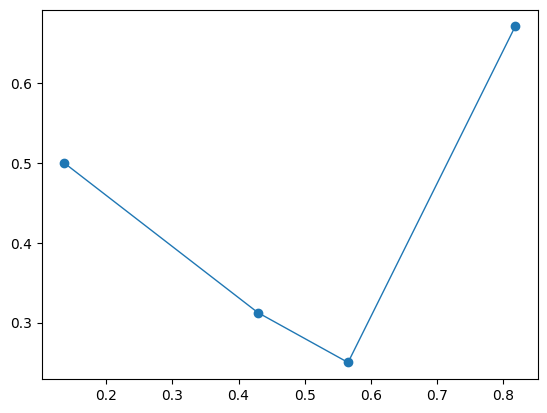

In [ ]:
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(x,y, marker='o', linewidth=1, label='rf')

plt.show()

In [ ]:
sklearn.calibration.calibration_curve()

<IPython.core.display.Javascript object>

AttributeError: module 'sklearn' has no attribute 'calibration'

In [ ]:
logreg_y, logreg_x = sklearn.calibration.calibration_curve(label_test, logreg_prediction[:,1], n_bins=10)

import numpy as np
>>> from sklearn.calibration import calibration_curve
>>> y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])
>>> y_pred = np.array([0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.8, 0.9,  1.])
>>> prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=3)

<IPython.core.display.Javascript object>

SyntaxError: invalid syntax (<ipython-input-252-90b7714b4823>, line 4)

In [ ]:
fig = plotly.subplots.make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "table"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]]
)